# Multiple Classifiers Ensemble System (MCS)

#### Iury Zanonni de Faria

### Imports

#### General imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statistics as st
import matplotlib.pyplot as plt
import warnings

#### Feature Selection imports

In [2]:
from sklearn.feature_selection import mutual_info_classif

#### Diversity imports

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

#### Classifiers imports

In [4]:
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


#### k-mean

In [5]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

#### Metrics

In [6]:
from sklearn.metrics import precision_score

In [7]:
from sklearn.model_selection import train_test_split

### Settings

In [8]:
DATA = ['Unnamed: 0', 'revenue','cost-goods-sold','gross-profit','research-development-expenses','selling-general-administrative-expenses','operating-expenses',
'operating-income','total-non-operating-income-expense','pre-tax-income','total-provision-income-taxes','income-after-taxes','income-from-continuous-operations',
'income-from-discontinued-operations','net-income','ebitda','ebit','basic-shares-outstanding','shares-outstanding','eps-basic-net-earnings-per-share',
'eps-earnings-per-share-diluted','cash-on-hand','receivables-total','inventory','other-current-assets','total-current-assets','net-property-plant-equipment',
'long-term-investments','goodwill-intangible-assets-total','other-long-term-assets','total-long-term-assets','total-assets','total-current-liabilities','long-term-debt',
'other-non-current-liabilities','total-long-term-liabilities','total-liabilities','common-stock-net','retained-earnings-accumulated-deficit','comprehensive-income',
'total-share-holder-equity','total-liabilities-share-holders-equity','net-income-loss','total-depreciation-amortization-cash-flow','other-non-cash-items','total-non-cash-items',
'change-in-accounts-receivable','change-in-inventories','change-in-accounts-payable','change-in-assets-liabilities','total-change-in-assets-liabilities',
'cash-flow-from-operating-activities','net-change-in-property-plant-equipment','net-change-in-intangible-assets','net-acquisitions-divestitures','investing-activities-other',
'cash-flow-from-investing-activities','net-long-term-debt','net-current-debt','debt-issuance-retirement-net-total','net-common-equity-issued-repurchased',
'net-total-equity-issued-repurchased','total-common-preferred-stock-dividends-paid','financial-activities-other','cash-flow-from-financial-activities',
'net-cash-flow','stock-based-compensation','common-stock-dividends-paid','current-ratio','long-term-debt-capital','debt-equity-ratio','gross-margin',
'operating-margin','ebit-margin','pre-tax-profit-margin','net-profit-margin','asset-turnover','inventory-turnover','receiveable-turnover','days-sales-in-receivables',
'roe','return-on-tangible-equity','roa','roi','book-value-per-share','operating-cash-flow-per-share','free-cash-flow-per-share','net-change-in-short-term-investments',
'net-change-in-long-term-investments','net-change-in-investments-total','other-operating-income-expenses','pre-paid-expenses','other-share-holders-equity','other-income',
'ebitda-margin']

REAL_RETURN_CLASS = "RealReturnClass"
REAL_RETURN = "RealReturn"
RISK_CLASS = 'RiskClass'
RISK = "Risk"

HIGH = 'high'
MEDIUM = 'medium'
LOW = 'low'

DATE = 'Unnamed: 0'

N_PERIODS = 2
N_FEATURES = 80

DATASET_PATH = 'new_dataset/process_final_{}.csv'.format(N_PERIODS)

MUTUAL_INFORMATION = "MUTUAL_INFORMATION"

SPEARMAN = "SPEARMAN"

ONE_R = "ONE_R"

FEATURE_SELECTION = SPEARMAN

#Remove os warnings do notebook
warnings.filterwarnings('ignore')

In [9]:
file = open(f'files_fusion/FUSION.txt', 'w+')

### Import dataset

In [10]:
dataset = pd.read_csv(DATASET_PATH)

### Data Frequency

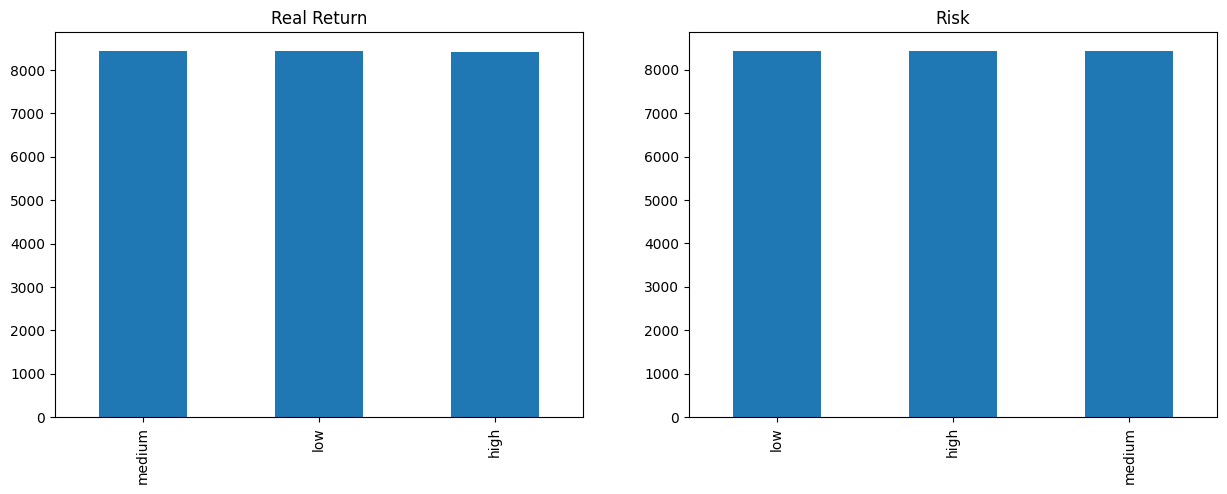

In [11]:
def plotResults(dataset:pd.DataFrame, title_1:str, title_2:str):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.set_figwidth(15)
  fig.set_figheight(5)

  x = dataset[REAL_RETURN_CLASS].value_counts()
  x.plot.bar(ax=axes[0])
  axes[0].set_title(title_1)

  x = dataset[RISK_CLASS].value_counts()
  x.plot.bar(ax=axes[1])
  axes[1].set_title(title_2)

plotResults(dataset, "Real Return", "Risk")

In [12]:
dataset = dataset.replace(to_replace=[HIGH], value=2.0)
dataset = dataset.replace(to_replace=[MEDIUM], value=1.0)
dataset = dataset.replace(to_replace=[LOW], value=0.0)

dataset = dataset.replace(to_replace=[np.NaN], value=0.0)

dataset_X = dataset.drop(columns=[REAL_RETURN_CLASS, REAL_RETURN, RISK_CLASS, RISK, DATE])
dataset_y = dataset.drop(columns=DATA)

### Feature Selection

In [13]:
file.write("######## FEATURES ########")
file.write("\n")

1

In [14]:
run_start_date = dt.datetime.now()
file.write(f"\nSTART: {run_start_date}\n")

35

In [15]:
def readFeatures(typeFeature, typeClass, num):
	file = open(f'./feature_selection/files/{typeFeature}_{typeClass}.txt', 'r')
	result = []
	
	for feature in file:
		result.append(eval(str(feature)))
	    
	file.close()
    
	return result[:num]

#### Real Return

In [16]:
final_ranking_real_return = readFeatures(FEATURE_SELECTION, REAL_RETURN, N_FEATURES)

#### Risk

In [17]:
final_ranking_risk  = readFeatures(FEATURE_SELECTION, RISK, N_FEATURES)

In [18]:
def getColumnsRank(rank: list):
  ranking = []
  for column in rank:
    ranking.append(column[0])
    
  return ranking

In [19]:
def getFeaturesSelection(feature_selection, type, n_features):
  final_rank = readFeatures(feature_selection, type, N_FEATURES)
  features = getColumnsRank(final_rank)[:n_features]
  return features

### Divisão do dataset

In [20]:
columns_dataset = DATA
columns_dataset.append(REAL_RETURN)
columns_dataset.append(RISK)
columns_dataset.append(REAL_RETURN_CLASS)
columns_dataset.append(RISK_CLASS)

df_train = None
df_test = None

df_train = pd.DataFrame(columns=columns_dataset)
df_test = pd.DataFrame(columns=columns_dataset)


In [21]:
df_train = pd.read_csv('./util/dataset_train.csv')
df_test = pd.read_csv('./util/dataset_test.csv')

In [22]:
def datasetTrainTest(feature_selection, type, n_features):
  features = getFeaturesSelection(feature_selection, type, n_features)

  if type == REAL_RETURN:
    class_type = REAL_RETURN_CLASS
  elif type == RISK:
    class_type = RISK_CLASS

  X_train = df_train[features]
  y_train = df_train[class_type]

  X_test = df_test[features]
  y_test = df_test[class_type]

  return X_train, y_train, X_test, y_test

##### Real Return

### Classificadores Únicos

In [23]:
file.write("\n######## CLASSIFICADORES UNICOS ########\n")

42

In [24]:
classifiers_real_return = {}
classifiers_risk = {}
dataset_classifiers = {}

In [25]:
RANDOM_FOREST = 'RANDOM_FOREST'
SVM = 'SVM'
DECISION_TREE = 'DECISION_TREE'
NEURAL_NETWORK = 'NEURAL_NETWORK'
LOGISTIC_REGRESSION ='LOGISTIC_REGRESSION'
XG_BOOST = 'XG_BOOST'

#### Random Forest

##### Real Return

In [26]:
X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(MUTUAL_INFORMATION, REAL_RETURN, 70)
dataset_classifiers[RANDOM_FOREST] = {REAL_RETURN: (MUTUAL_INFORMATION, 70)}

randon_forest_return = RandomForestClassifier(n_estimators = 840, max_depth = 178, min_samples_split = 4, min_samples_leaf = 6, max_features = 'sqrt')
classifiers_real_return[RANDOM_FOREST] = randon_forest_return

randon_forest_return.fit(X_real_return_train, y_real_return_train)

result_randon_forest_return = randon_forest_return.score(X_real_return_test, y_real_return_test)
result_randon_forest_return

0.8407036992408724

##### Risk

In [27]:
X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(ONE_R, RISK, 80)
dataset_classifiers[RANDOM_FOREST][RISK] = (ONE_R, 80)

randon_forest_risk = RandomForestClassifier(n_estimators = 622, max_depth = 70, min_samples_split = 3, min_samples_leaf = 9, max_features = 'log2')

classifiers_risk[RANDOM_FOREST] = randon_forest_risk
randon_forest_risk.fit(X_risk_train, y_risk_train)

result_randon_forest_risk = randon_forest_risk.score(X_risk_test, y_risk_test)
result_randon_forest_risk

0.5253645017471985

In [28]:
file.write(f"RANDOM FOREST:({result_randon_forest_return},{result_randon_forest_risk})\n")

54

#### SVM

##### Real Return

In [29]:
X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(MUTUAL_INFORMATION, REAL_RETURN, 1)
dataset_classifiers[SVM] = {REAL_RETURN: (MUTUAL_INFORMATION, 1)}

svm_real_return = SVC(kernel = 'rbf', C = 99.94849891435051, class_weight = 'balanced')
classifiers_real_return[SVM] = svm_real_return

svm_real_return.fit(X_real_return_train, y_real_return_train)

result_svm_return = svm_real_return.score(X_real_return_test, y_real_return_test)
result_svm_return

0.834919869863839

##### Risk

In [30]:
X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(MUTUAL_INFORMATION, RISK, 80)
dataset_classifiers[SVM][RISK] = (MUTUAL_INFORMATION, 80)

svm_risk = SVC(kernel = 'rbf', C = 99.89489576327396, class_weight = 'balanced')
classifiers_risk[SVM] = svm_risk

svm_risk.fit(X_risk_train, y_risk_train)

result_svm_risk = svm_risk.score(X_risk_test, y_risk_test)
result_svm_risk

0.4430654295698277

In [31]:
file.write(f"SVM:({result_svm_return},{result_svm_risk})\n")

43

#### Decision Tree

##### Real Return

In [32]:
X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(SPEARMAN, REAL_RETURN, 40)
dataset_classifiers[DECISION_TREE] = {REAL_RETURN: (SPEARMAN, 40)}

decision_tree_real_return = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, min_samples_split = 1097)
classifiers_real_return[DECISION_TREE] = decision_tree_real_return

decision_tree_real_return.fit(X_real_return_train, y_real_return_train)

result_decision_return = decision_tree_real_return.score(X_real_return_test, y_real_return_test)
result_decision_return

0.8350403663091939

##### Risk

In [33]:
X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(SPEARMAN, RISK, 30)
dataset_classifiers[DECISION_TREE][RISK] = (SPEARMAN, 30)

decision_tree_risk = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 133, min_samples_split = 919)
classifiers_risk[DECISION_TREE] = decision_tree_risk

decision_tree_risk.fit(X_risk_train, y_risk_train)

result_decision_risk = decision_tree_risk.score(X_risk_test, y_risk_test)
result_decision_risk

0.4835522352090613

In [34]:
file.write(f"DECISION TREE:({result_decision_return},{result_decision_risk})\n")

54

#### Rede Neural

##### Real Return

In [35]:
X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(SPEARMAN, REAL_RETURN, 1)
dataset_classifiers[NEURAL_NETWORK] = {REAL_RETURN: (SPEARMAN, 1)}

neural_return = MLPClassifier(activation = 'logistic', solver = 'lbfgs', max_iter = 500, hidden_layer_sizes = (300,), learning_rate = 'constant')
classifiers_real_return[NEURAL_NETWORK] = neural_return

neural_return.fit(X_real_return_train, y_real_return_train)

result_neural_return = neural_return.score(X_real_return_test, y_real_return_test)
result_neural_return

0.8347993734184842

##### Risk

In [36]:
X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(SPEARMAN, RISK, 30)
dataset_classifiers[NEURAL_NETWORK][RISK] = (SPEARMAN, 30)

neural_risk = MLPClassifier(activation = 'logistic', solver = 'lbfgs', max_iter = 500, hidden_layer_sizes = (300,), learning_rate = 'constant')
classifiers_risk[NEURAL_NETWORK] = neural_risk

neural_risk.fit(X_risk_train, y_risk_train)

result_neural_risk = neural_risk.score(X_risk_test, y_risk_test)
result_neural_risk

0.4360766357392457

In [37]:
file.write(f"NEURAL NETWORK:({result_neural_return},{result_decision_risk})\n")

55

#### Regressão Logística

##### Real Return

In [38]:
X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(MUTUAL_INFORMATION, REAL_RETURN, 1)
dataset_classifiers[LOGISTIC_REGRESSION] = {REAL_RETURN: (MUTUAL_INFORMATION, 1)}

rl_return = LogisticRegression(penalty = 'l2', C = 48.72671442481355, class_weight = 'balanced', solver = 'lbfgs', max_iter = 97847, n_jobs=-1)
classifiers_real_return[LOGISTIC_REGRESSION] = rl_return

rl_return.fit(X_real_return_train, y_real_return_train)

result_rl_return = rl_return.score(X_real_return_test, y_real_return_test)
result_rl_return

0.8337149054102904

##### Risk

In [39]:
X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(SPEARMAN, RISK, 70)
dataset_classifiers[LOGISTIC_REGRESSION][RISK] = (SPEARMAN, 70)

rl_risk = LogisticRegression(penalty = 'l2', C = 48.72671442481355, class_weight = 'balanced', solver = 'lbfgs', max_iter = 97847, n_jobs=-1)
classifiers_risk[LOGISTIC_REGRESSION] = rl_risk

rl_risk.fit(X_risk_train, y_risk_train)

result_rl_risk = rl_risk.score(X_risk_test, y_risk_test)
result_rl_risk

/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.45692252078563683

In [40]:
file.write(f"LOGISTIC REGRESSION:({result_rl_return},{result_rl_risk})\n")

61

#### XGboost

##### Real Return

In [41]:
X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(MUTUAL_INFORMATION, REAL_RETURN, 94)
dataset_classifiers[XG_BOOST] = {REAL_RETURN: (MUTUAL_INFORMATION, 94)}

xg_boost_return = xgboost.XGBClassifier()
classifiers_real_return[XG_BOOST] = xg_boost_return

xg_boost_return.fit(X_real_return_train, y_real_return_train)

result_xgboost_result = xg_boost_return.score(X_real_return_test, y_real_return_test)
result_xgboost_result

0.8356428485359682

##### Risk

In [42]:
X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(ONE_R, RISK, 94)
dataset_classifiers[XG_BOOST][RISK] = (ONE_R, 94)

xg_boost_risk = xgboost.XGBClassifier()
classifiers_risk[XG_BOOST] = xg_boost_risk

xg_boost_risk.fit(X_risk_train, y_risk_train)

result_xgboost_risk = xg_boost_risk.score(X_risk_test, y_risk_test)
result_xgboost_risk

0.5133148572117122

In [43]:
file.write(f"XGBOOST:({result_xgboost_result},{result_xgboost_risk})\n")

48

### Cross-validation

In [44]:
CV = 10
result_cv_real_return = {}
result_cv_risk = {}

In [45]:
def datasetXY(feature_selection, type, n_features):
  features = getFeaturesSelection(feature_selection, type, n_features)

  class_type = REAL_RETURN_CLASS if type == REAL_RETURN else RISK_CLASS

  X_dataset = dataset[features]
  y_dataset = dataset[class_type]  

  return X_dataset, y_dataset

##### Real Return

In [46]:
X_dataset_real_return, y_dataset_real_return = datasetXY(MUTUAL_INFORMATION, REAL_RETURN, 70)

cv_result = cross_val_score(classifiers_real_return[RANDOM_FOREST], X_dataset_real_return, y_dataset_real_return, cv=CV, n_jobs=-1)
result_cv_real_return[RANDOM_FOREST] = cv_result.mean()

X_dataset_real_return, y_dataset_real_return = datasetXY(MUTUAL_INFORMATION, REAL_RETURN, 1)

cv_result = cross_val_score(classifiers_real_return[SVM], X_dataset_real_return, y_dataset_real_return, cv=CV, n_jobs=-1)
result_cv_real_return[SVM] = cv_result.mean()

X_dataset_real_return, y_dataset_real_return = datasetXY(SPEARMAN, REAL_RETURN, 40)

cv_result = cross_val_score(classifiers_real_return[DECISION_TREE], X_dataset_real_return, y_dataset_real_return, cv=CV, n_jobs=-1)
result_cv_real_return[DECISION_TREE] = cv_result.mean()

X_dataset_real_return, y_dataset_real_return = datasetXY(SPEARMAN, REAL_RETURN, 1)

cv_result = cross_val_score(classifiers_real_return[NEURAL_NETWORK], X_dataset_real_return, y_dataset_real_return, cv=CV, n_jobs=-1)
result_cv_real_return[NEURAL_NETWORK] = cv_result.mean()

X_dataset_real_return, y_dataset_real_return = datasetXY(MUTUAL_INFORMATION, REAL_RETURN, 1)

cv_result = cross_val_score(classifiers_real_return[LOGISTIC_REGRESSION], X_dataset_real_return, y_dataset_real_return, cv=CV, n_jobs=-1)
result_cv_real_return[LOGISTIC_REGRESSION] = cv_result.mean()

X_dataset_real_return, y_dataset_real_return = datasetXY(SPEARMAN, REAL_RETURN, 94)

cv_result = cross_val_score(classifiers_real_return[XG_BOOST], X_dataset_real_return, y_dataset_real_return, cv=CV, n_jobs=-1)
result_cv_real_return[XG_BOOST] = cv_result.mean()

result_cv_real_return

/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_mult

{'RANDOM_FOREST': 0.813753004249285,
 'SVM': 0.8363947290748864,
 'DECISION_TREE': 0.8360782736752024,
 'NEURAL_NETWORK': 0.8380943025847085,
 'LOGISTIC_REGRESSION': 0.8352483434659238,
 'XG_BOOST': 0.7809952166260895}

##### Risk

In [47]:
X_dataset_risk, y_dataset_risk = datasetXY(ONE_R, RISK, 80)

cv_result = cross_val_score(classifiers_risk[RANDOM_FOREST], X_dataset_risk, y_dataset_risk, cv=CV, n_jobs=-1)
result_cv_risk[RANDOM_FOREST] = cv_result.mean()

X_dataset_risk, y_dataset_risk = datasetXY(MUTUAL_INFORMATION, RISK, 80)

cv_result = cross_val_score(classifiers_risk[SVM], X_dataset_risk, y_dataset_risk, cv=CV, n_jobs=-1)
result_cv_risk[SVM] = cv_result.mean()

X_dataset_risk, y_dataset_risk = datasetXY(SPEARMAN, RISK, 30)

cv_result = cross_val_score(classifiers_risk[DECISION_TREE], X_dataset_risk, y_dataset_risk, cv=CV, n_jobs=-1)
result_cv_risk[DECISION_TREE] = cv_result.mean()

X_dataset_risk, y_dataset_risk = datasetXY(SPEARMAN, RISK, 30)

cv_result = cross_val_score(classifiers_risk[NEURAL_NETWORK], X_dataset_risk, y_dataset_risk, cv=CV, n_jobs=-1)
result_cv_risk[NEURAL_NETWORK] = cv_result.mean()

X_dataset_risk, y_dataset_risk = datasetXY(SPEARMAN, RISK, 70)

cv_result = cross_val_score(classifiers_risk[LOGISTIC_REGRESSION], X_dataset_risk, y_dataset_risk, cv=CV, n_jobs=-1)
result_cv_risk[LOGISTIC_REGRESSION] = cv_result.mean()

X_dataset_risk, y_dataset_risk = datasetXY(ONE_R, RISK, 94)

cv_result = cross_val_score(classifiers_risk[XG_BOOST], X_dataset_risk, y_dataset_risk, cv=CV, n_jobs=-1)
result_cv_risk[XG_BOOST] = cv_result.mean()

result_cv_risk

/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_mult

{'RANDOM_FOREST': 0.4689171896936485,
 'SVM': 0.40584574204762136,
 'DECISION_TREE': 0.4659940375704895,
 'NEURAL_NETWORK': 0.427266261987716,
 'LOGISTIC_REGRESSION': 0.4267906418903619,
 'XG_BOOST': 0.4632265051698855}

In [48]:
file.write("\n######## CV ########\n")
file.write(f"Real Return: {result_cv_real_return}\n")
file.write(f"Risk: {result_cv_risk}\n")

221

### Selection Of Cassifier

#### List of Sets

In [49]:
classifiers = list(result_cv_real_return.keys())
list_sets = []

for i in range(len(classifiers)):
  for j in range(i + 1, len(classifiers)):
    list_sets.append((classifiers[i], classifiers[j]))

list_sets


[('RANDOM_FOREST', 'SVM'),
 ('RANDOM_FOREST', 'DECISION_TREE'),
 ('RANDOM_FOREST', 'NEURAL_NETWORK'),
 ('RANDOM_FOREST', 'LOGISTIC_REGRESSION'),
 ('RANDOM_FOREST', 'XG_BOOST'),
 ('SVM', 'DECISION_TREE'),
 ('SVM', 'NEURAL_NETWORK'),
 ('SVM', 'LOGISTIC_REGRESSION'),
 ('SVM', 'XG_BOOST'),
 ('DECISION_TREE', 'NEURAL_NETWORK'),
 ('DECISION_TREE', 'LOGISTIC_REGRESSION'),
 ('DECISION_TREE', 'XG_BOOST'),
 ('NEURAL_NETWORK', 'LOGISTIC_REGRESSION'),
 ('NEURAL_NETWORK', 'XG_BOOST'),
 ('LOGISTIC_REGRESSION', 'XG_BOOST')]

#### Real Return Classifiers

In [50]:
real_return_classifiers = []

for classifier_set in list_sets:  
  set_0 = result_cv_real_return[classifier_set[0]]
  set_1 = result_cv_real_return[classifier_set[1]]

  avg = (set_0 + set_1) / 2
  if avg >= 0.75:
    if classifier_set[0] not in real_return_classifiers:
      real_return_classifiers.append(classifier_set[0])

    if classifier_set[1] not in real_return_classifiers:
      real_return_classifiers.append(classifier_set[1])

real_return_classifiers


['RANDOM_FOREST',
 'SVM',
 'DECISION_TREE',
 'NEURAL_NETWORK',
 'LOGISTIC_REGRESSION',
 'XG_BOOST']

#### Risk Classifiers

In [51]:
risk_classifiers = []

for classifier_set in list_sets:  
  set_0 = result_cv_risk[classifier_set[0]]
  set_1 = result_cv_risk[classifier_set[1]]

  avg = (set_0 + set_1) / 2
  if avg >= 0.45:
    if classifier_set[0] not in risk_classifiers:
      risk_classifiers.append(classifier_set[0])

    if classifier_set[1] not in risk_classifiers:
      risk_classifiers.append(classifier_set[1])

risk_classifiers

['RANDOM_FOREST', 'DECISION_TREE', 'XG_BOOST']

In [52]:
file.write("\n######## CLASSIFIERS SELECTION ########\n")
file.write(f"Real Return: {real_return_classifiers}\n")
file.write(f"Risk: {risk_classifiers}\n")

53

### Fusion of Classifiers

#### Training with diversification

##### Whitout diversity

In [53]:
file.write("\n######## WHITOUT DIVERSITY ########\n")

37

In [54]:
dataset_classifiers

{'RANDOM_FOREST': {'RealReturn': ('MUTUAL_INFORMATION', 70),
  'Risk': ('ONE_R', 80)},
 'SVM': {'RealReturn': ('MUTUAL_INFORMATION', 1),
  'Risk': ('MUTUAL_INFORMATION', 80)},
 'DECISION_TREE': {'RealReturn': ('SPEARMAN', 40), 'Risk': ('SPEARMAN', 30)},
 'NEURAL_NETWORK': {'RealReturn': ('SPEARMAN', 1), 'Risk': ('SPEARMAN', 30)},
 'LOGISTIC_REGRESSION': {'RealReturn': ('MUTUAL_INFORMATION', 1),
  'Risk': ('SPEARMAN', 70)},
 'XG_BOOST': {'RealReturn': ('MUTUAL_INFORMATION', 94), 'Risk': ('ONE_R', 94)}}

Real Return

In [55]:
real_return_whitout_diversity = {}

for classifier in real_return_classifiers:
  feature_selection = dataset_classifiers[classifier][REAL_RETURN][0]
  n_feature_selection = dataset_classifiers[classifier][REAL_RETURN][1]

  X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(feature_selection, REAL_RETURN, n_feature_selection)

  real_return_whitout_diversity[classifier] = classifiers_real_return[classifier]
  real_return_whitout_diversity[classifier].fit(X_real_return_train, y_real_return_train)

  file.write(f"Real Return: {classifier}, {real_return_whitout_diversity[classifier].score(X_real_return_test, y_real_return_test)}\n")
  print(classifier, real_return_whitout_diversity[classifier].score(X_real_return_test, y_real_return_test))

RANDOM_FOREST 0.8407036992408724
SVM 0.834919869863839
DECISION_TREE 0.8350403663091939
NEURAL_NETWORK 0.8350403663091939
LOGISTIC_REGRESSION 0.8337149054102904
XG_BOOST 0.8356428485359682


Risk

In [56]:
risk_whitout_diversity = {}

for classifier in risk_classifiers:
  feature_selection = dataset_classifiers[classifier][RISK][0]
  n_feature_selection = dataset_classifiers[classifier][RISK][1]

  X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(feature_selection, RISK, n_feature_selection)

  risk_whitout_diversity[classifier] = classifiers_risk[classifier]
  risk_whitout_diversity[classifier].fit(X_risk_train, y_risk_train)

  file.write(f"Risk: {classifier}, {risk_whitout_diversity[classifier].score(X_risk_test, y_risk_test)}\n")
  print(classifier, risk_whitout_diversity[classifier].score(X_risk_test, y_risk_test))

RANDOM_FOREST 0.5227135799493915
DECISION_TREE 0.48379322809977104
XG_BOOST 0.5133148572117122


##### Bagging

In [57]:
file.write("\n######## BAGGING ########\n")

27

Real Return

In [58]:
real_return_bagging = {}
count = 0
for classifier in real_return_classifiers:
  feature_selection = dataset_classifiers[classifier][REAL_RETURN][0]
  n_feature_selection = dataset_classifiers[classifier][REAL_RETURN][1]

  X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(feature_selection, REAL_RETURN, n_feature_selection)
  
  estimator = classifiers_real_return[classifier]
  real_return_bagging[classifier] = BaggingClassifier(estimator=estimator, n_jobs=-1)
  real_return_bagging[classifier].fit(X_real_return_train, y_real_return_train)

  file.write(f"Real Return: {classifier}, {real_return_bagging[classifier].score(X_real_return_test, y_real_return_test)}\n")
  print(classifier, real_return_bagging[classifier].score(X_real_return_test, y_real_return_test))
  

RANDOM_FOREST 0.8413061814676467
SVM 0.8345583805277744
DECISION_TREE 0.834919869863839


/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/iuryfaria/Documents/cefet/TCC2/tcc-mcs/env/lib/python3.9/site-packages/sklearn/neural_network/_mult

NEURAL_NETWORK 0.8341968911917098
LOGISTIC_REGRESSION 0.834076394746355
XG_BOOST 0.8415471743583565


Risk

In [59]:
risk_bagging = {}

for classifier in risk_classifiers:
  feature_selection = dataset_classifiers[classifier][RISK][0]
  n_feature_selection = dataset_classifiers[classifier][RISK][1]

  X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(feature_selection, RISK, n_feature_selection)
  
  estimator = classifiers_risk[classifier]
  risk_bagging[classifier] = BaggingClassifier(estimator=estimator, n_jobs=-1)
  risk_bagging[classifier].fit(X_risk_train, y_risk_train)

  file.write(f"Risk: {classifier}, {risk_bagging[classifier].score(X_risk_test, y_risk_test)}\n")
  print(classifier, risk_bagging[classifier].score(X_risk_test, y_risk_test))

RANDOM_FOREST 0.5231955657308109
DECISION_TREE 0.4817447885287384
XG_BOOST 0.5250030124111339


##### AdaBoost

In [60]:
file.write("\n######## ADABOOST ########\n")

28

Real Return

In [61]:
real_return_adaboost = {}

for classifier in real_return_classifiers:
  feature_selection = dataset_classifiers[classifier][REAL_RETURN][0]
  n_feature_selection = dataset_classifiers[classifier][REAL_RETURN][1]

  X_real_return_train, y_real_return_train, X_real_return_test, y_real_return_test = datasetTrainTest(feature_selection, REAL_RETURN, n_feature_selection)
  
  estimator = classifiers_real_return[classifier]
  try:
    real_return_adaboost[classifier] = AdaBoostClassifier(estimator=estimator)
    real_return_adaboost[classifier].fit(X_real_return_train, y_real_return_train)
    file.write(f"RealReturn: {classifier}, {real_return_adaboost[classifier].score(X_real_return_test, y_real_return_test)}\n")
    print(classifier, real_return_adaboost[classifier].score(X_real_return_test, y_real_return_test))
  except:
    real_return_adaboost.pop(classifier)
    print(classifier, "Não utilizado")


RANDOM_FOREST 0.8399807205687432
SVM Não utilizado
DECISION_TREE 0.7872032775033136
NEURAL_NETWORK Não utilizado
LOGISTIC_REGRESSION 0.7750331365224726
XG_BOOST 0.3214845162067719


Risk

In [62]:
risk_adaboost = {}

for classifier in risk_classifiers:
  feature_selection = dataset_classifiers[classifier][RISK][0]
  n_feature_selection = dataset_classifiers[classifier][RISK][1]

  X_risk_train, y_risk_train, X_risk_test, y_risk_test = datasetTrainTest(feature_selection, RISK, n_feature_selection)

  estimator = classifiers_risk[classifier]
  try:
    risk_adaboost[classifier] = AdaBoostClassifier(estimator=estimator)
    risk_adaboost[classifier].fit(X_risk_train, y_risk_train)
    file.write(f"Risk: {classifier}, {risk_adaboost[classifier].score(X_risk_test, y_risk_test)}\n")
    print(classifier, risk_adaboost[classifier].score(X_risk_test, y_risk_test))
  except:
    risk_adaboost.pop(classifier)
    print(classifier, "Não utilizado")

RANDOM_FOREST 0.5260874804193276
DECISION_TREE 0.4502952162911194
XG_BOOST 0.30075912760573564


#### Fusion

In [63]:
def fusion(fusion_model, models, type, y_data_final):
  df_fusion = pd.DataFrame()

  for model in models:
    feature_selection = dataset_classifiers[model][type][0]
    n_feature_selection = dataset_classifiers[model][type][1]

    X_data, y_data = datasetXY(feature_selection, type, n_feature_selection)
  
    X_predict = models[model].predict(X_data)
    
    df_fusion[model] = X_predict

  X_train, X_test, y_train, y_test = train_test_split(df_fusion, y_data_final, test_size=0.4, random_state=42)

  print(X_train)
  fusion_model.fit(X_train, y_train)
  
  return fusion_model.score(X_test, y_test)

In [64]:
def testFusionClassifiers(model_fusion, model_fusion_name, X_dataset_real_return, y_dataset_real_return, X_dataset_risk, y_dataset_risk):
  
  whiout_return = fusion(model_fusion, real_return_whitout_diversity, REAL_RETURN, y_dataset_real_return)
  whiout_risk = fusion(model_fusion, risk_whitout_diversity, RISK, y_dataset_risk)

  file.write(f"[WHITOUT] [{model_fusion_name}] RealReturn: {whiout_return}\n")
  file.write(f"[WHITOUT] [{model_fusion_name}] Risk: {whiout_risk}\n") if len(risk_classifiers) > 0 else file.write(f"[WHITOUT] [{model_fusion_name}] Risk: -\n")

  bagging_return = fusion(model_fusion, real_return_bagging, REAL_RETURN, y_dataset_real_return)
  bagging_risk = fusion(model_fusion, risk_bagging, RISK, y_dataset_risk)

  file.write(f"[BAGGING] [{model_fusion_name}] RealReturn: {bagging_return}\n")
  file.write(f"[BAGGING] [{model_fusion_name}] Risk: {bagging_risk}\n") if len(risk_classifiers) > 0 else file.write(f"[BAGGING] [{model_fusion_name}] Risk: -\n")

  ada_return = fusion(model_fusion, real_return_adaboost, REAL_RETURN, y_dataset_real_return)
  ada_risk = fusion(model_fusion, risk_adaboost, RISK, y_dataset_risk)

  file.write(f"[ADABOOST] [{model_fusion_name}] RealReturn: {ada_return}\n")
  file.write(f"[ADABOOST] [{model_fusion_name}] Risk: {ada_risk}\n") if len(risk_classifiers) > 0 else file.write(f"[ADABOOST] [{model_fusion_name}] Risk: -\n")
  

In [65]:
file.write("\n######## FUSION ########\n")

26

In [66]:
models = {
  RANDOM_FOREST: RandomForestClassifier(),
  SVM: SVC(),
  DECISION_TREE: DecisionTreeClassifier(),
  NEURAL_NETWORK: MLPClassifier(),
  LOGISTIC_REGRESSION: LogisticRegression(),
  XG_BOOST: xgboost.XGBClassifier()
}

In [67]:
for key in models.keys():
  print(key)
  feature_selection = dataset_classifiers[key][REAL_RETURN][0]
  n_feature_selection = dataset_classifiers[key][REAL_RETURN][1]

  X_dataset_real_return, y_dataset_real_return = datasetXY(feature_selection, REAL_RETURN, n_feature_selection)

  feature_selection = dataset_classifiers[key][RISK][0]
  n_feature_selection = dataset_classifiers[key][RISK][1]

  X_dataset_risk, y_dataset_risk = datasetXY(feature_selection, RISK, n_feature_selection)

  testFusionClassifiers(models[key], key, X_dataset_real_return, y_dataset_real_return, X_dataset_risk, y_dataset_risk)

RANDOM_FOREST
       RANDOM_FOREST  SVM  DECISION_TREE  NEURAL_NETWORK  LOGISTIC_REGRESSION  \
9102             2.0  2.0            2.0             2.0                  2.0   
14651            2.0  2.0            2.0             2.0                  2.0   
4514             2.0  2.0            2.0             2.0                  2.0   
23469            2.0  2.0            2.0             2.0                  2.0   
20719            1.0  1.0            1.0             1.0                  1.0   
...              ...  ...            ...             ...                  ...   
21575            2.0  2.0            2.0             2.0                  2.0   
5390             1.0  1.0            1.0             1.0                  1.0   
860              1.0  1.0            1.0             1.0                  1.0   
15795            1.0  1.0            1.0             1.0                  1.0   
23654            2.0  2.0            2.0             2.0                  2.0   

       XG_BOO

In [68]:
run_end_date = dt.datetime.now()
file.write(f"\nEND: {run_end_date}")
file.write(f"\nTOTAL EXEC: {run_end_date-run_start_date}")

file.close()